In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import time
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets
from sklearn.svm import SVC

# PHYS710 ASSIGNMENT
Author: Halil İbrahim Olgun

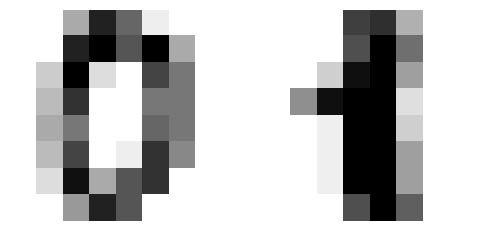

In [2]:
# Load digits dataset
digits = datasets.load_digits(n_class=2)

# Plot example '0' and '1'
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [3]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [4]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.79923362  0.26571862 -0.16474421  0.17815209] 0
[0.41948352 0.83602799 0.72200828 0.373356  ] 1


In [5]:
data_enc = sample_train[0]

## ZFeatureMap

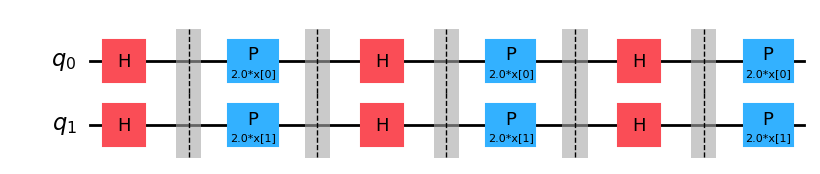

In [6]:
#no entanglement no quantum advantage
map_z = ZFeatureMap(2, reps=3, insert_barriers=True)
map_z.decompose().draw('mpl', fold=-1)

## TwoLocal

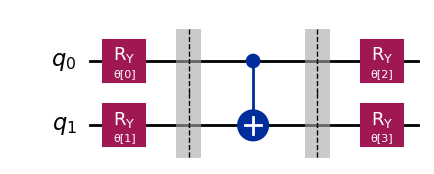

In [7]:
map_tw = TwoLocal(2, 'ry', 'cx', 'linear', reps=1, insert_barriers=True)
map_tw.decompose().draw('mpl', fold=-1)

## ZZFeatureMap

others are also straight forward applications, since we have entanlements in this feature map, I'll use ZZFeatureMap for implementation

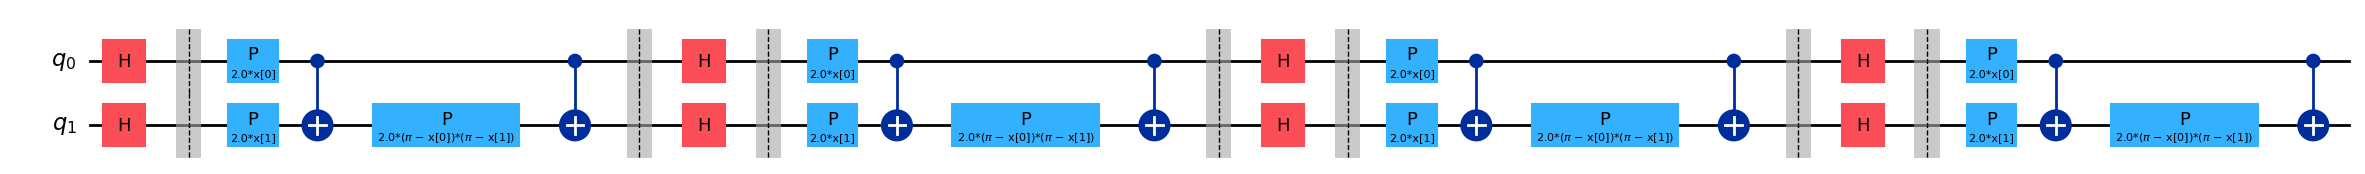

In [8]:
#ZZFeatureMap has entanglements
map_zz = ZZFeatureMap(2, reps=4, insert_barriers=True)
map_zz.decompose().draw('mpl', fold=-1)

#### Question

Encode the data point $x = (-0.1,0.2)$ using the `ZZFeatureMap` with 4 repetitions and default data mapping function.

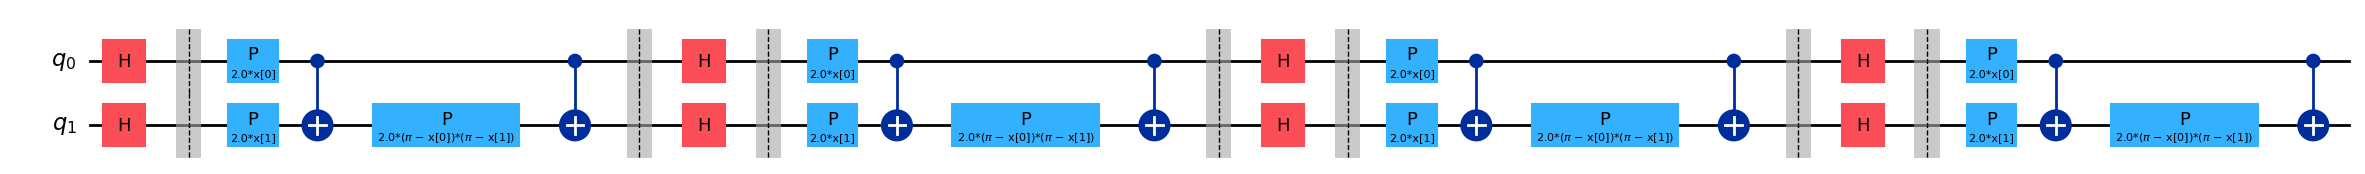

In [9]:
x = [-0.1, 0.2]

map_zz = ZZFeatureMap(2, reps=4, insert_barriers=True)
encoded_zz = map_zz.assign_parameters(x)
map_zz.decompose().draw('mpl', fold=-1)

## Compute Training Kernel Matrix

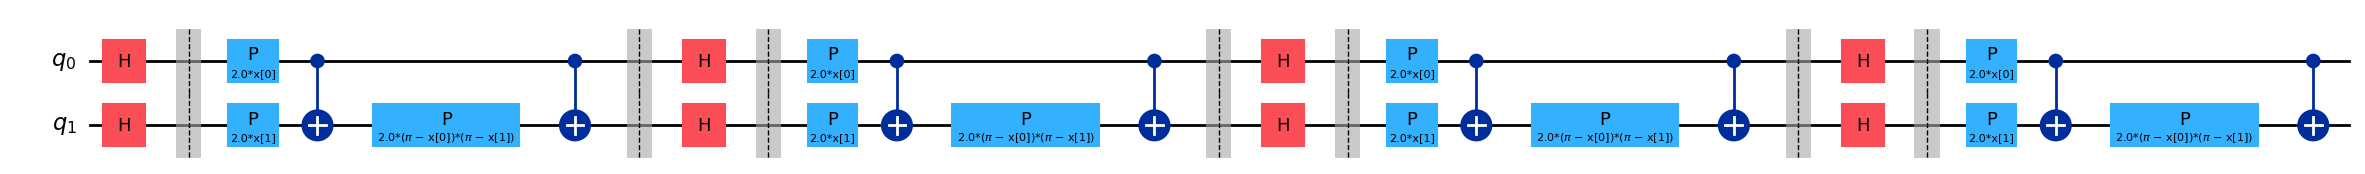

In [10]:
zz_map = ZZFeatureMap(feature_dimension=2, reps=4, entanglement='linear', insert_barriers=True)
zz_kernel = FidelityQuantumKernel(feature_map=zz_map)
zz_kernel.feature_map.decompose().draw("mpl", fold=-1)

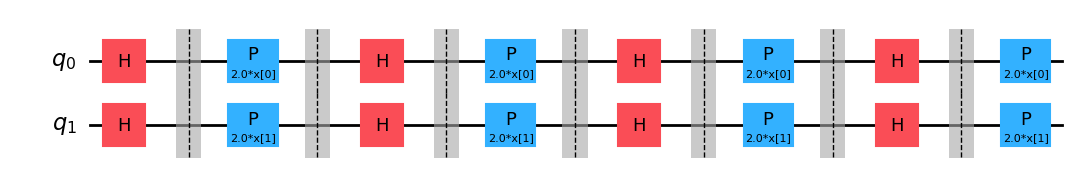

In [11]:
z_map = ZFeatureMap(feature_dimension=2, reps=4, insert_barriers=True)
z_kernel = FidelityQuantumKernel(feature_map=z_map)
z_kernel.feature_map.decompose().draw("mpl", fold=-1)

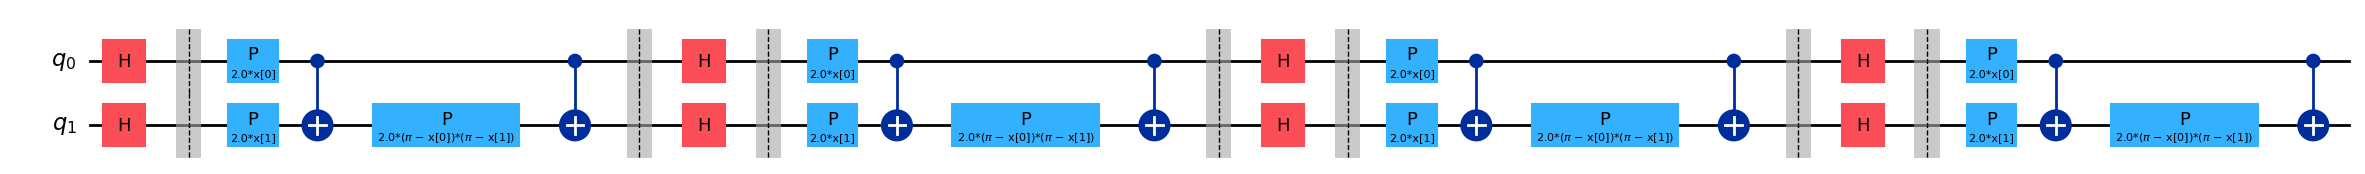

In [12]:
p_map = PauliFeatureMap(feature_dimension=2, reps=4, insert_barriers=True)
p_kernel = FidelityQuantumKernel(feature_map=p_map)
p_kernel.feature_map.decompose().draw("mpl", fold=-1)

### PauliFeatureMap and ZZ are identical in the above setting so I'll only train for Z and ZZ for comparison

evaluation took 49.020036935806274 seconds using ZZFeatureMap.
evaluation took 26.869999647140503 seconds using ZFeatureMap.


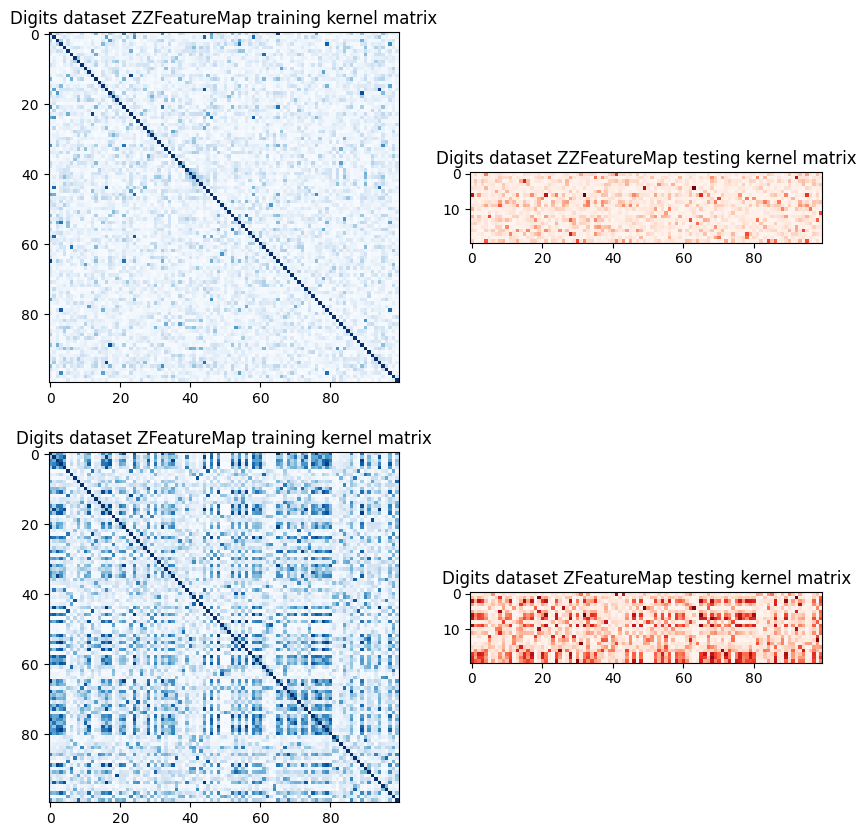

In [13]:
start_zz = time.time()
matrix_train_zz = zz_kernel.evaluate(x_vec=sample_train)
matrix_test_zz = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)
end_zz = time.time()

start_z = time.time()
matrix_train_z = z_kernel.evaluate(x_vec=sample_train)
matrix_test_z = z_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)
end_z = time.time()

print("evaluation took " + str(end_zz-start_zz) + " seconds using ZZFeatureMap.")
print("evaluation took " + str(end_z-start_z) + " seconds using ZFeatureMap.")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].imshow(
    np.asmatrix(matrix_train_zz), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0][0].set_title("Digits dataset ZZFeatureMap training kernel matrix")

axs[0][1].imshow(np.asmatrix(matrix_test_zz), interpolation="nearest", origin="upper", cmap="Reds")
axs[0][1].set_title("Digits dataset ZZFeatureMap testing kernel matrix")


axs[1][0].imshow(
    np.asmatrix(matrix_train_z), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[1][0].set_title("Digits dataset ZFeatureMap training kernel matrix")

axs[1][1].imshow(np.asmatrix(matrix_test_z), interpolation="nearest", origin="upper", cmap="Reds")
axs[1][1].set_title("Digits dataset ZFeatureMap testing kernel matrix")

plt.show()

### Question

Calculate the transition amplitute between 
 and 
 using the ZZFeatureMap with 4 repetitions and default data mapping function. Use the qasm_simulator with shots = 8192, seed_simulator = 1024 and seed_transpiler = 1024.

In [14]:
# 4 reps as asked above
q_map = ZZFeatureMap(feature_dimension=2, reps=4)
#tried other maps below
#zz_map = PauliFeatureMap(feature_dimension=2, reps=4)

# input 
x = [-0.1, 0.2]
y = [0.4, -0.6]

# build kernel from same feature map
q_kernel = QuantumCircuit(q_map.num_qubits)
q_kernel.compose(q_map.assign_parameters(x), inplace=True)
q_kernel.compose(q_map.assign_parameters(y), inplace=True)

# measure
q_kernel.measure_all()

# using qasm_simulator
backend = Aer.get_backend('qasm_simulator')
q_circuit = transpile(q_kernel, backend=backend)

# simulation with the given parameters
job = backend.run(q_circuit, shots=8192, seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts()

# transition amplitude
amplitude = counts.get('00', 0) / sum(counts.values())
print(f"Transition amplitude: {amplitude}")

Transition amplitude: 0.0877685546875


## Quantum Support Vector Classification

In [15]:
zz_svc = SVC(kernel="precomputed")
zz_svc.fit(matrix_train_zz, label_train)
zz_score = zz_svc.score(matrix_test_zz, label_test)

z_svc = SVC(kernel="precomputed")
z_svc.fit(matrix_train_z, label_train)
z_score = zz_svc.score(matrix_test_z, label_test)

print(f"PreComputed ZZkernel classification test score: {zz_score}")
print(f"PreComputed Zkernel classification test score: {z_score}")

PreComputed ZZkernel classification test score: 0.75
PreComputed Zkernel classification test score: 0.8


### Below is the other way of doing SVC using quantum kernel

instead of precomputing the matrix kernel, we directly pass it to the QSVC funtion

In [16]:
from qiskit_machine_learning.algorithms import QSVC

s = time.time()
qsvc = QSVC(quantum_kernel=zz_kernel)
qsvc.fit(sample_train, label_train)
qsvc_score = qsvc.score(sample_test, label_test)
e = time.time()

print(f"QSVC kernel evaluation took: {e-s} seconds.")
print(f"QSVC classification test score: {qsvc_score}")

QSVC kernel evaluation took: 48.984036922454834 seconds.
QSVC classification test score: 0.75


# Sklearn Breast Cancer Dataset

choose another dataset and see how QSVC performs

I'll try different dimension size for this one

In [17]:
canc = datasets.load_breast_cancer()
sample_train, sample_test, label_train, label_test = train_test_split(
     canc.data, canc.target, test_size=0.2, random_state=22)

# Reduce dimensions
n_dim = 3
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]


print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.67877167 -0.32887698 -0.64391848] 0
[-0.68758509  0.0201601  -0.71602497] 1


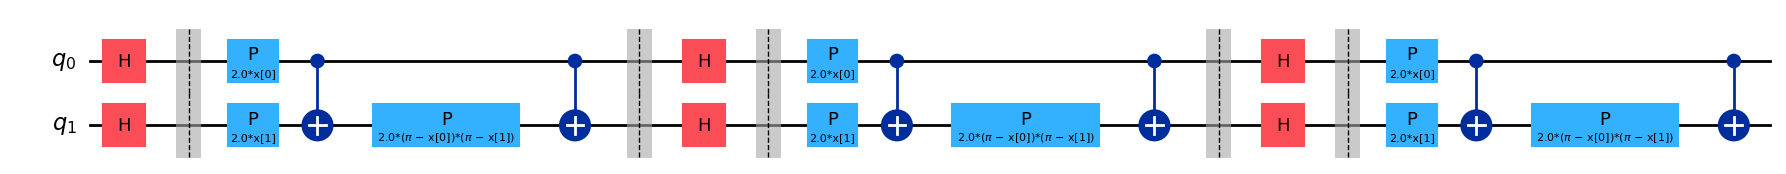

In [18]:
p_map = PauliFeatureMap(feature_dimension=2, reps=3, insert_barriers=True)
p_kernel = FidelityQuantumKernel(feature_map=p_map)
p_kernel.feature_map.decompose().draw("mpl", fold=-1)

evaluation took 33.66102886199951 seconds using PauliFeatureMap.


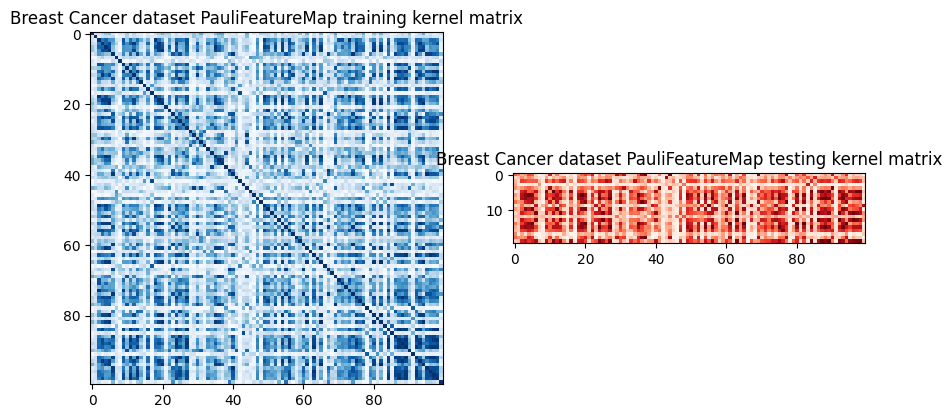

In [19]:
start_p = time.time()
matrix_train_p = p_kernel.evaluate(x_vec=sample_train)
matrix_test_p = p_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)
end_p = time.time()

print("evaluation took " + str(end_p-start_p) + " seconds using PauliFeatureMap.")

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(
    np.asmatrix(matrix_train_p), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Breast Cancer dataset PauliFeatureMap training kernel matrix")

axs[1].imshow(np.asmatrix(matrix_test_p), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Breast Cancer dataset PauliFeatureMap testing kernel matrix")

plt.show()

In [20]:
p_svc = SVC(kernel="precomputed")
p_svc.fit(matrix_train_p, label_train)
p_score = p_svc.score(matrix_test_p, label_test)

print(f"PreComputed PauliFeatureMap classification test score using Breast Cancer Data: {p_score}")

PreComputed PauliFeatureMap classification test score using Breast Cancer Data: 0.95


# Iris Dataset

In [21]:
iris = datasets.load_iris()
sample_train, sample_test, label_train, label_test = train_test_split(
     iris.data, iris.target, test_size=0.2, random_state=22)

# Reduce dimensions
n_dim = 3
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]


print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.81937179 -0.22339024 -0.14574461] 0
[-0.79894958  0.41111913 -0.14729938] 0


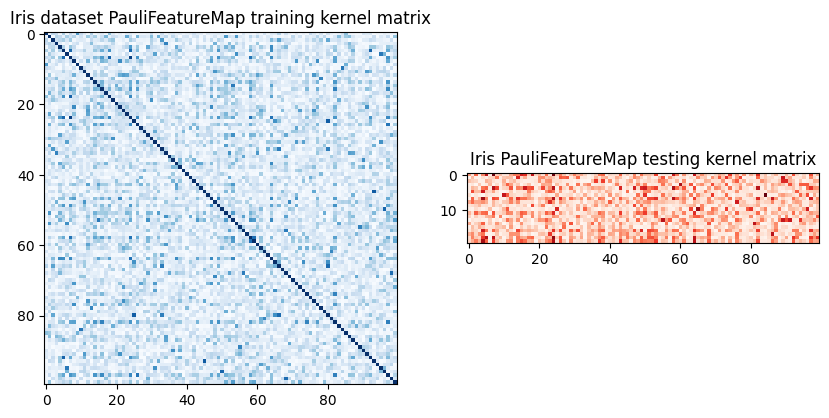

evaluation took 34.04299592971802 seconds using PauliFeatureMap.
PreComputed PauliFeatureMap classification test score using Iris dataset: 0.95


In [22]:
iris_kernel = FidelityQuantumKernel(feature_map=p_map)

start_p = time.time()
matrix_train_iris = iris_kernel.evaluate(x_vec=sample_train)
matrix_test_iris = iris_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)
end_p = time.time()

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(
    np.asmatrix(matrix_train_iris), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Iris dataset PauliFeatureMap training kernel matrix")

axs[1].imshow(np.asmatrix(matrix_test_iris), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Iris PauliFeatureMap testing kernel matrix")

plt.show()

iris_svc = SVC(kernel="precomputed")
iris_svc.fit(matrix_train_iris, label_train)
iris_score = p_svc.score(matrix_test_iris, label_test)

print("evaluation took " + str(end_p-start_p) + " seconds using PauliFeatureMap.")
print(f"PreComputed PauliFeatureMap classification test score using Iris dataset: {p_score}")